# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
# Load csv
bird_traits = pd.read_csv('BirdTraitData.csv', encoding='latin1')  

In [3]:
bird_traits.columns


Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet: invertebrates',
       'Diet: vertebrates', 'Diet: fruits', 'Diet: flower/nectar/pollen/gums',
       'Diet: seeds', 'Diet: other plant materials',
       'Diet: scavenge; garbage; carrion; offal; carcasses', 'TrophicLevel',
       'ActivityCycle', 'ForagingStratum', 'MigratoryStatus', 'IncubationTime',
       'ClutchSize', 'EggLength', 'EggWidth', 'EggMass', 'NestingHabit',
       'MaxLongevity', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid',
       'Alaotra.Mangoro', 'Amoron.i.Mania', 'Analamanga', 'Analanjirofo',
       'Androy', 'Anosy', 'Atsimo.Andrefana', 'Atsimo.Atsinanana',
       'Atsinanana', 'Betsiboka', 'Boeny', 'Bongolava', 'DIANA',
       'Haute.Matsiatra', 'Ihorombe', 'Itasy', 'Melaky', 'Menabe', 'SAVA',
       'Sofia', 'Vakinankaratra', 'Vatovavy.Fitovinany', 'Antananarivo',
       'Antsiranana', 'Fianarantsoa', 'Mahajanga', 'Toamasina', 'Toliara',
 

In [5]:
# Find and replace in columns
bird_traits.columns = bird_traits.columns.str.replace('Diet: ', 'Diet_')

# Rename columns as needed
bird_traits = bird_traits.rename(columns={'Diet_flower/nectar/pollen/gums': 'Diet_flowers', 'Diet_other plant materials' : 'Diet_plants', 'Diet: scavenge; garbage; carrion; offal; carcasses' : 'diet_other'})
bird_traits.columns

Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet_invertebrates',
       'Diet_vertebrates', 'Diet_fruits', 'Diet_flowers', 'Diet_seeds',
       'Diet_plants', 'Diet_scavenge; garbage; carrion; offal; carcasses',
       'TrophicLevel', 'ActivityCycle', 'ForagingStratum', 'MigratoryStatus',
       'IncubationTime', 'ClutchSize', 'EggLength', 'EggWidth', 'EggMass',
       'NestingHabit', 'MaxLongevity', 'Dry', 'Humid', 'Montane', 'Subarid',
       'Subhumid', 'Alaotra.Mangoro', 'Amoron.i.Mania', 'Analamanga',
       'Analanjirofo', 'Androy', 'Anosy', 'Atsimo.Andrefana',
       'Atsimo.Atsinanana', 'Atsinanana', 'Betsiboka', 'Boeny', 'Bongolava',
       'DIANA', 'Haute.Matsiatra', 'Ihorombe', 'Itasy', 'Melaky', 'Menabe',
       'SAVA', 'Sofia', 'Vakinankaratra', 'Vatovavy.Fitovinany',
       'Antananarivo', 'Antsiranana', 'Fianarantsoa', 'Mahajanga', 'Toamasina',
       'Toliara', 'References'],
      dtype='object')

In [6]:
bird_traits = bird_traits.rename(columns={'Diet_flower/nectar/pollen/gums': 'Diet_flowers', 'Diet_other plant materials' : 'Diet_plants', 'Diet_scavenge; garbage; carrion; offal; carcasses' : 'diet_other'})

In [7]:
bird_traits.columns

Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet_invertebrates',
       'Diet_vertebrates', 'Diet_fruits', 'Diet_flowers', 'Diet_seeds',
       'Diet_plants', 'diet_other', 'TrophicLevel', 'ActivityCycle',
       'ForagingStratum', 'MigratoryStatus', 'IncubationTime', 'ClutchSize',
       'EggLength', 'EggWidth', 'EggMass', 'NestingHabit', 'MaxLongevity',
       'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid', 'Alaotra.Mangoro',
       'Amoron.i.Mania', 'Analamanga', 'Analanjirofo', 'Androy', 'Anosy',
       'Atsimo.Andrefana', 'Atsimo.Atsinanana', 'Atsinanana', 'Betsiboka',
       'Boeny', 'Bongolava', 'DIANA', 'Haute.Matsiatra', 'Ihorombe', 'Itasy',
       'Melaky', 'Menabe', 'SAVA', 'Sofia', 'Vakinankaratra',
       'Vatovavy.Fitovinany', 'Antananarivo', 'Antsiranana', 'Fianarantsoa',
       'Mahajanga', 'Toamasina', 'Toliara', 'References'],
      dtype='object')

In [8]:
bird_traits = bird_traits.loc[:, ['AdultBodyMass', 'DietBreadth', 'Diet_invertebrates', 
                                  'Diet_vertebrates', 'Diet_fruits', 'Diet_flowers', 
                                  'Diet_seeds', 'Diet_plants', 
                                  'diet_other',  
                                  'TrophicLevel', 'ActivityCycle', 'ForagingStratum', 
                                  'MigratoryStatus', 'IncubationTime', 'ClutchSize', 
                                  'EggLength', 'EggWidth', 'EggMass', 'NestingHabit', 
                                  'MaxLongevity', 'Subarid']]

In [9]:
test = ['AdultBodyMass', 'DietBreadth', 'Diet_Invertebrates', 'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds','Diet_Plants', 'Diet_Other', 'TrophicLevel', 'ActivityCycle', 'ForagingStratum', 'MigratoryStatus', 'IncubationTime','ClutchSize', 'EggLength', 'EggWidth', 'EggMass', 'NestingHabit', 'MaxLongevity', 'Subarid']

In [10]:
print(bird_traits.columns)

Index(['AdultBodyMass', 'DietBreadth', 'Diet_invertebrates',
       'Diet_vertebrates', 'Diet_fruits', 'Diet_flowers', 'Diet_seeds',
       'Diet_plants', 'diet_other', 'TrophicLevel', 'ActivityCycle',
       'ForagingStratum', 'MigratoryStatus', 'IncubationTime', 'ClutchSize',
       'EggLength', 'EggWidth', 'EggMass', 'NestingHabit', 'MaxLongevity',
       'Subarid'],
      dtype='object')


### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [11]:
# Create dictionary to store encoders
label_encoders = {}

# Identify categorical columns
categorical_cols = bird_traits.select_dtypes(include=['object']).columns

# Initialize LabelEncoder and encode each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    bird_traits[col] = le.fit_transform(bird_traits[col])
    label_encoders[col] = le  # Store the encoder for potential inverse transformation

# Print the df
print(bird_traits.head())

   AdultBodyMass  DietBreadth  Diet_invertebrates  Diet_vertebrates  \
0          138.5            2                   2                 2   
1         1050.0            1                   1                 2   
2          181.0            2                   2                 2   
3          292.0            2                   2                 2   
4          511.0            2                   2                 2   

   Diet_fruits  Diet_flowers  Diet_seeds  Diet_plants  diet_other  \
0            1             1           1            1           1   
1            1             1           1            1           1   
2            1             1           1            1           1   
3            1             1           1            1           1   
4            1             1           1            1           1   

   TrophicLevel  ...  ForagingStratum  MigratoryStatus  IncubationTime  \
0             3  ...                3                0            31.0   
1         

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [12]:
# Define features
X = bird_traits.drop(columns=["Subarid"])  # Drop target variable from features
y = bird_traits["Subarid"]  # Target variable

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=808)

# Initialize and train Bagging Classifier
bagging_clf = BaggingClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=808)
bagging_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = bagging_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy and OOB score
print(f"Test Accuracy: {accuracy:.4f}")
print(f"OOB Score: {bagging_clf.oob_score_:.4f}")

Test Accuracy: 0.9452
OOB Score: 0.8817


### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [13]:
# Generate predictions
y_pred = bagging_clf.predict(X_test)

# Calculate model accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Retrieve OOB score
oob_score = bagging_clf.oob_score_

# Print evaluation metrics
print(f"Out-of-Bag (OOB) Score: {oob_score:.4f}")
print(f"Test Accuracy Score: {test_accuracy:.4f}")

Out-of-Bag (OOB) Score: 0.8817
Test Accuracy Score: 0.9452


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

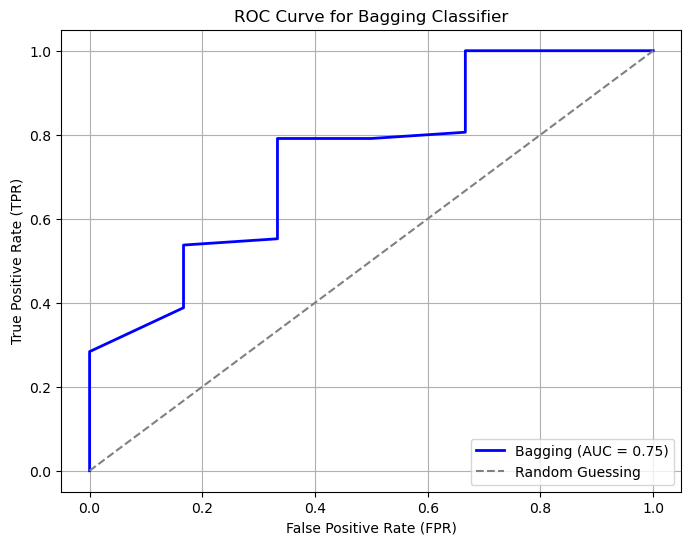

In [14]:
# Step 1: Compute predicted probabilities
y_prob = bagging_clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Step 2: Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_bagging = auc(fpr, tpr)  # Compute AUC

# Step 3: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Bagging (AUC = {roc_auc_bagging:.2f})", color="blue", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Bagging Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

When doing the Accuracy test, the score was 0.9452. Based on that score, I would have expected the AUC to be higher. The AUC being 0.75 implies that this model did better than just random guessing. That being said, I wouldn't trust many of my day to day life decisions on a model that predicted things correctly only 75% of the time. Based on these numbers, I think the model could be biased towards a majority class, this could imply our dataset is imbalanced.

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [15]:
# Separate majority and minority classes

majority_class = y_train.value_counts().idxmax()  # Identify majority class (0 or 1)
minority_class = y_train.value_counts().idxmin()  # Identify minority class

X_train_majority = X_train[y_train == majority_class]
X_train_minority = X_train[y_train == minority_class]

y_train_majority = y_train[y_train == majority_class]
y_train_minority = y_train[y_train == minority_class]

# Upsample the minority class
X_train_minority_upsampled, y_train_minority_upsampled = resample(
    X_train_minority, y_train_minority,
    replace=True,  # Sample with replacement
    n_samples=len(y_train_majority),
    random_state=808
)

# Combine majority and upsampled minority class
X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the dataset
X_train_balanced, y_train_balanced = resample(
    X_train_balanced, y_train_balanced, random_state=808
)

# Print value counts 
print("Resampled class distribution:")
print(y_train_balanced.value_counts())

Resampled class distribution:
Subarid
0    159
1    141
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

Test Accuracy (Balanced Model): 0.8767
OOB Score (Balanced Model): 0.9700
ROC AUC (Balanced Model): 0.7189


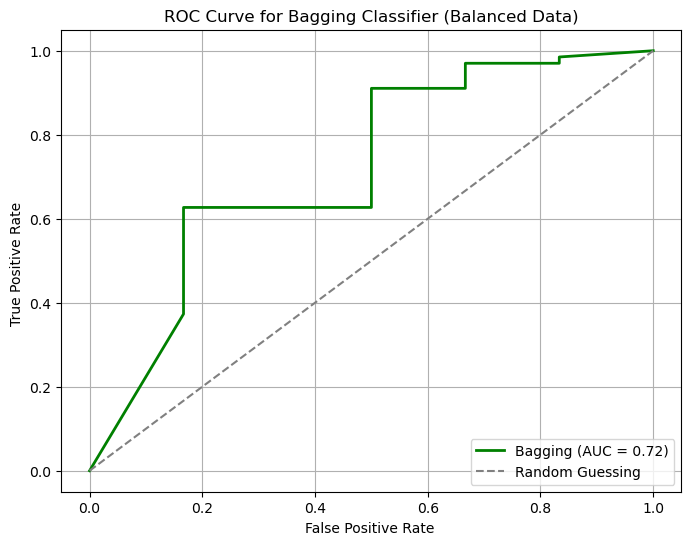

In [16]:
# Retrain the Bagging Classifier with the balanced dataset
bagging_clf_balanced = BaggingClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=808)
bagging_clf_balanced.fit(X_train_balanced, y_train_balanced)

# Evaluate accuracy on the test data
y_pred_balanced = bagging_clf_balanced.predict(X_test)
test_accuracy_balanced = accuracy_score(y_test, y_pred_balanced)

# Calculate ROC curve and AUC 
y_prob_balanced = bagging_clf_balanced.predict_proba(X_test)[:, 1]  
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_prob_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

# Print metrics
print(f"Test Accuracy (Balanced Model): {test_accuracy_balanced:.4f}")
print(f"OOB Score (Balanced Model): {bagging_clf_balanced.oob_score_:.4f}")
print(f"ROC AUC (Balanced Model): {roc_auc_balanced:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, label=f"Bagging (AUC = {roc_auc_balanced:.2f})", color="green", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.xlabel("False Positive Rate ")
plt.ylabel("True Positive Rate ")
plt.title("ROC Curve for Bagging Classifier (Balanced Data)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

So, I can see here that the accuracy score went down, and the AUC also went down, but only a little bit. While both numbers are lower than I would like, they are closer together than they were before, which is good. Balancing the data did help the accuracy score and the AUC be more in like with each other. The OOB score is very promising at 0.9700, but its also hard to reconsile with the accuracy score. 

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

Top 10 most important features:
            Feature  Importance  Standard Deviation
18     NestingHabit    0.068493            0.017328
0     AdultBodyMass    0.032877            0.028865
4       Diet_fruits    0.010959            0.010251
5      Diet_flowers    0.010959            0.010251
11  ForagingStratum    0.009589            0.006278
19     MaxLongevity    0.006849            0.006849
15        EggLength    0.006849            0.006849
16         EggWidth    0.006849            0.006849
10    ActivityCycle    0.006849            0.018632
17          EggMass    0.005479            0.016438


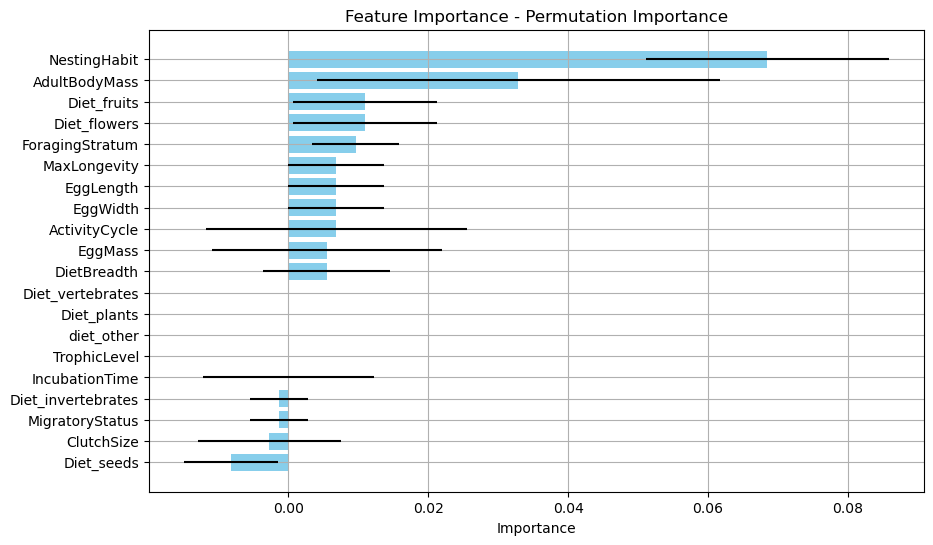

In [17]:
result = permutation_importance(
    bagging_clf_balanced, X_test, y_test, n_repeats=10, random_state=808
)

#  Extract feature importance values 
importance_values = result.importances_mean
importance_std = result.importances_std

# Create DataFrame 
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': importance_values,
    'Standard Deviation': importance_std
})

# Sort the features in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print("Top 10 most important features:")
print(importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Standard Deviation'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance - Permutation Importance")
plt.gca().invert_yaxis()  # Reverse order so the most important feature is at the top
plt.grid(True)
plt.show()

What features are most important in our model of species distribution?

Based on this graph, it appears that Nesting Habitat, Adult body mass, and its diet being fruits or flowers are all important in our model of species distribution. It shoul be noted, that Nesting habit is significantly more important, than the other variables, and while Adult Body Mass is much lower than the nesting habitat, it is still much higher than the other variables